In [48]:
import os
import glob
import numpy
from nilearn import plotting, image, masking, input_data
import warnings
import importlib
from community import community_louvain
import networkx as nx
from nilearn.datasets import load_mni152_gm_template
import nibabel as nib

#import utils
#importlib.reload(utils) # reupdate imported codes, useful for debugging

##################
# SETTING UP NECESSARY INFO
##################

### NEED TO BE UPDATED
data_path = '/srv/tempdd/egermani/pipeline_transition/data/original/stat_maps/group_level/group_50'

contrast = 'rh'

In [51]:
data_fpath = glob.glob(f'{data_path}/*/original/n_1_*{contrast}*')
print(len(data_fpath))

24


/srv/tempdd/egermani/workEnv/lib/python3.10/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/srv/tempdd/egermani/workEnv/lib/python3.10/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/srv/tempdd/egermani/workEnv/lib/python3.10/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains

/srv/tempdd/egermani/workEnv/lib/python3.10/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/srv/tempdd/egermani/workEnv/lib/python3.10/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/srv/tempdd/egermani/workEnv/lib/python3.10/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains

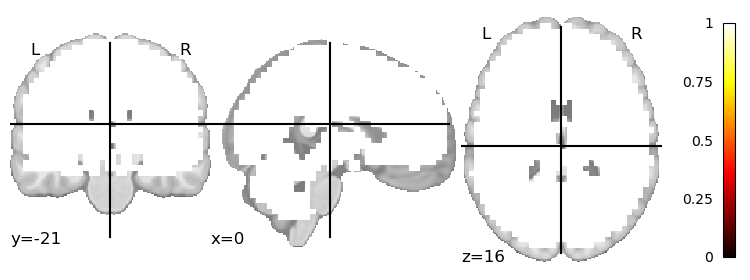

In [52]:
img_list = []
mask_list = []
target = load_mni152_gm_template(4)

for fpath in data_fpath:
    img = nib.load(fpath)
    
    mask_img = image.binarize_img(img)
    
    #resampled_gm = image.resample_to_img(
    #            img,
    #            target,
    #            interpolation='continuous')
    
    resampled_mask = image.resample_to_img(
                mask_img,
                target,
                interpolation='nearest')
    
    mask_list.append(resampled_mask)
    #img_list.append(resampled_gm)
    
mask = masking.intersect_masks(mask_list, threshold=1)
    
plotting.plot_stat_map(mask)

In [53]:
data_fpath = glob.glob(f'{data_path}/*/original/n_*_*{contrast}*')
print(len(data_fpath))

24000


In [ ]:
import numpy as np
target = load_mni152_gm_template(4)
Qs=[]
for n in range(1,1001):
    data_fpath = sorted(glob.glob(f'{data_path}/*/original/n_{n}_*{contrast}*'))
    data = []
    for fpath in data_fpath:
        img = nib.load(fpath)

        resampled_gm = image.resample_to_img(
                    img,
                    target,
                   interpolation='continuous')

        masked_resampled_gm_data = resampled_gm.get_fdata() * mask.get_fdata()

        masked_resampled_gm = nib.Nifti1Image(masked_resampled_gm_data, affine=resampled_gm.affine)

        data.append(np.reshape(masked_resampled_gm_data,-1))
    Q = numpy.corrcoef(data)  
    Qs.append(Q)

In [17]:
# Compute per group
partitioning = {}
groupnums = [i for i in range(1000)]
for i,group in enumerate(groupnums):
    print(group)
    correlation_matrix = Qs[i]
    G = nx.Graph(numpy.abs(correlation_matrix))  # must be positive value for graphing
    partition = community_louvain.best_partition(G, random_state=0)
    partitioning['{}_partition'.format(group)] = [partition, G, correlation_matrix]

0
1
2
3
4
5
6
7
8
9
10
11


In [39]:
##############
# build a matrix which summarize all hypothese louvain community into one community
##############

matrix_graph = numpy.zeros((24, 24))
# teams per partition
for key_i in partitioning.keys():
    print('\n***** Doing ****')
    print(key_i)
    # build summary matrix for alltogether matrix
    for key_j in partitioning[key_i][0].keys():
        community_key_j = partitioning[key_i][0][key_j]
        for team in range(len(partitioning[key_i][0].keys())):
            if team == key_j: # a team should not be counted as belonging to same community of itself
                continue
            if partitioning[key_i][0][team] == community_key_j:
                # # debugging
                print(partitioning[key_i][0][team], " == ", community_key_j, ' thus adding 1 at row: ', subject[team], " col: ", subject[key_j])
                matrix_graph[team][key_j] += 1


***** Doing ****
0_partition
0  ==  0  thus adding 1 at row:  DATASET_SOFT_FSL_FWHM_5_MC_PARAM_24_HRF_0  col:  DATASET_SOFT_FSL_FWHM_5_MC_PARAM_0_HRF_0
0  ==  0  thus adding 1 at row:  DATASET_SOFT_FSL_FWHM_5_MC_PARAM_24_HRF_1  col:  DATASET_SOFT_FSL_FWHM_5_MC_PARAM_0_HRF_0
0  ==  0  thus adding 1 at row:  DATASET_SOFT_FSL_FWHM_5_MC_PARAM_6_HRF_0  col:  DATASET_SOFT_FSL_FWHM_5_MC_PARAM_0_HRF_0
0  ==  0  thus adding 1 at row:  DATASET_SOFT_FSL_FWHM_8_MC_PARAM_0_HRF_0  col:  DATASET_SOFT_FSL_FWHM_5_MC_PARAM_0_HRF_0
0  ==  0  thus adding 1 at row:  DATASET_SOFT_FSL_FWHM_8_MC_PARAM_24_HRF_0  col:  DATASET_SOFT_FSL_FWHM_5_MC_PARAM_0_HRF_0
0  ==  0  thus adding 1 at row:  DATASET_SOFT_FSL_FWHM_8_MC_PARAM_24_HRF_1  col:  DATASET_SOFT_FSL_FWHM_5_MC_PARAM_0_HRF_0
0  ==  0  thus adding 1 at row:  DATASET_SOFT_FSL_FWHM_8_MC_PARAM_6_HRF_0  col:  DATASET_SOFT_FSL_FWHM_5_MC_PARAM_0_HRF_0
1  ==  1  thus adding 1 at row:  DATASET_SOFT_FSL_FWHM_5_MC_PARAM_6_HRF_1  col:  DATASET_SOFT_FSL_FWHM_5_MC_PARA

In [44]:
subject = [img.split('/')[-3].split('_')[2]+','+img.split('/')[-3].split('_')[4]+','+img.split('/')[-3].split('_')[7] +',' + img.split('/')[-3].split('_')[9] for img in data_fpath]

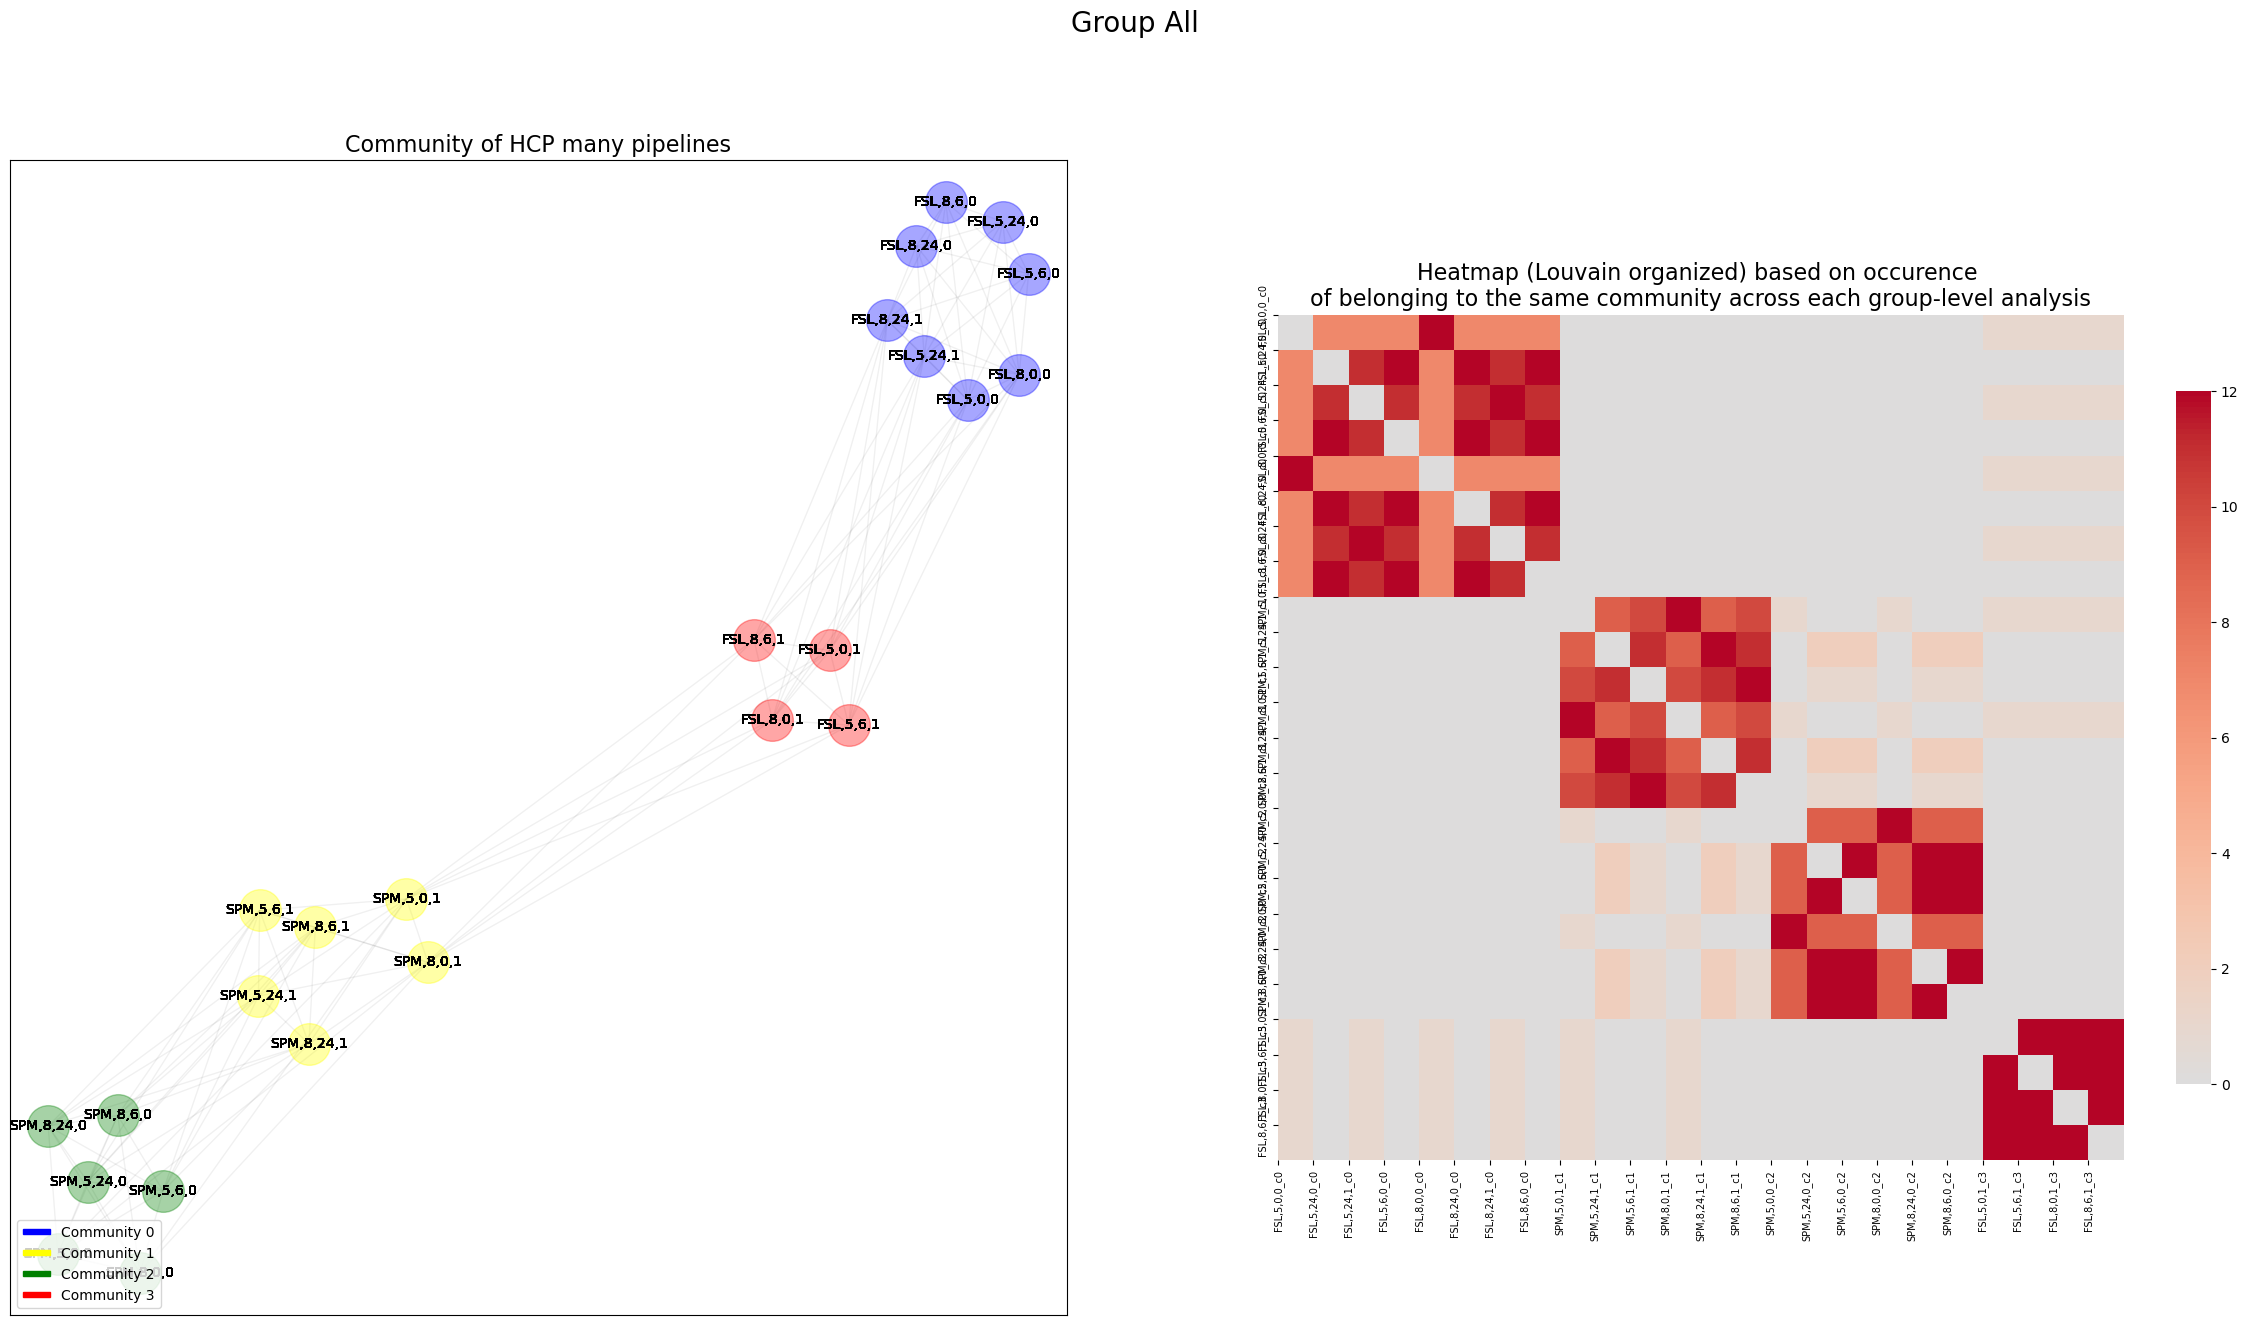

In [46]:
import utils
G = nx.Graph(matrix_graph, seed=0)
# compute the best partition
partition = community_louvain.best_partition(G, random_state=0)
#saving_name = '{}/graph_community_alltogether.png'.format(results_dir)
title_graph = "Community of HCP many pipelines"
title_heatmap = "Heatmap (Louvain organized) based on occurence \nof belonging to the same community across each group-level analysis"
#saving_name = '{}/graph_and_heatmap_all_hyp.png'.format(results_dir)

utils.build_both_graph_heatmap(matrix_graph, G, partition, title_graph, title_heatmap, subject, "All")

